# Yankees - Event Propensity - Next Event Buyer
* Ryan Kazmerik, Joey Lai
* Oct 14, 2022

## Hypothesis
Each team has different tier (or quality) of games, based on day of the week, time of the season, opponent, etc. We think that by using previous buyer behaviour we can make a prediction on whether the fan will purchase for the next game or not.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [74]:
import getpass
import matplotlib.pyplot as plt
import pyodbc
import pandas as pd
import seaborn as sns
import warnings

from pandas_profiling import ProfileReport
from pycaret.classification import *
from shared_utilities import helpers

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

### Let's connect to RedShift and run a stored proc to get our dataset:

In [3]:
df = helpers.get_event_propensity_training_dataset(
    cluster="prod-app",
    database="stlryankees",
    lkupclientid="53",
    start_year=2010,
    end_year=2021
)

df.shape

Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com


(227882, 17)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227882 entries, 0 to 227881
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   daysout              227882 non-null  object        
 1   mindaysout           227882 non-null  int64         
 2   maxdaysout           127324 non-null  float64       
 3   dimcustomermasterid  227882 non-null  int64         
 4   recent_openrate      227882 non-null  float64       
 5   recent_clickrate     227882 non-null  float64       
 6   eventdate            227882 non-null  datetime64[ns]
 7   eventname            227882 non-null  object        
 8   inmarket             224927 non-null  object        
 9   distancetovenue      199288 non-null  float64       
 10  tenure               227882 non-null  int64         
 11  did_purchase         227882 non-null  int64         
 12  events_purchased     227882 non-null  int64         
 13  frequency_oppo

### We should create separate out some data for training the model and some for evaluating:

In [5]:
# copy your main dataframe
df_dataset = df

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True)
df_eval.reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (193700, 17)
Unseen Data For Predictions: (34182, 17)



### Now we can model the data using a binary classification prediction for the target field to see how likely a customer is to purchase:

In [25]:
setup(
    data= df_train, 
    target="did_purchase", 
    train_size = 0.80,
    data_split_shuffle=True,
    categorical_features=["inmarket"],
    date_features=["eventdate"],
    ignore_features=[
        "count_merchowned",
        "dimcustomermasterid",
        "eventname",
        "mindaysout",
        "maxdaysout"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "distancetovenue",
        "events_purchased",
        "frequency_eventday",
        "frequency_opponent",
        "frequency_eventtime",
        "recent_clickrate",
        "recent_openrate",
        "tenure"
    ]
);

In [26]:
model_matrix = compare_models(
    fold= 10, 
    include= ["lr"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8268,0.9098,0.8123,0.8366,0.8242,0.6537,0.6540,4.8850


### The top model is performing well, so let's compare it against our test dataset:

In [27]:
best_model = create_model(
    model_matrix, 
    fold= 10
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8245,0.9062,0.8129,0.8321,0.8224,0.6489,0.6491
1,0.8295,0.9113,0.8127,0.8409,0.8265,0.6590,0.6594
2,0.8260,0.9111,0.8062,0.8394,0.8225,0.6520,0.6525
3,0.8274,0.9085,0.8125,0.8374,0.8248,0.6549,0.6552
4,0.8292,0.9110,0.8153,0.8386,0.8268,0.6585,0.6587
5,0.8247,0.9103,0.8085,0.8354,0.8218,0.6493,0.6497
6,0.8271,0.9087,0.8102,0.8384,0.8241,0.6541,0.6545
7,0.8224,0.9067,0.8131,0.8285,0.8207,0.6448,0.6449
8,0.8309,0.9131,0.8219,0.8369,0.8293,0.6618,0.6620


### We can also see the correlation between the features and the target variable:

In [30]:
cor = df.corr()

df_correlated = df

corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,mindaysout,maxdaysout,dimcustomermasterid,recent_openrate,recent_clickrate,distancetovenue,tenure,did_purchase,events_purchased,frequency_opponent,frequency_eventday,frequency_eventtime,count_merchowned
mindaysout,1.00,0.98,0.02,-0.03,-0.03,-0.12,-0.04,0.35,0.01,-0.05,0.03,-0.05,0.03
maxdaysout,0.98,1.00,-0.00,-0.00,-0.01,0.01,0.06,-0.03,0.05,-0.15,-0.09,-0.15,-0.02
dimcustomermasterid,0.02,-0.00,1.00,-0.01,-0.00,-0.01,-0.02,0.07,-0.01,0.03,0.03,0.03,-0.01
recent_openrate,-0.03,-0.00,-0.01,1.00,0.36,-0.04,-0.02,0.08,-0.03,0.04,0.03,0.03,0.03
recent_clickrate,-0.03,-0.01,-0.00,0.36,1.00,-0.02,-0.02,0.04,-0.01,0.02,0.02,0.02,0.01
distancetovenue,-0.12,0.01,-0.01,-0.04,-0.02,1.00,0.05,-0.35,0.02,-0.09,-0.11,-0.11,-0.02
tenure,-0.04,0.06,-0.02,-0.02,-0.02,0.05,1.00,-0.16,0.95,-0.14,-0.19,-0.24,0.03
did_purchase,0.35,-0.03,0.07,0.08,0.04,-0.35,-0.16,1.00,-0.08,0.27,0.28,0.29,0.07
events_purchased,0.01,0.05,-0.01,-0.03,-0.01,0.02,0.95,-0.08,1.00,-0.13,-0.17,-0.23,0.03
frequency_opponent,-0.05,-0.15,0.03,0.04,0.02,-0.09,-0.14,0.27,-0.13,1.00,0.42,0.58,0.03


### This plot lists the most important features for a correct prediction (either Score_0 or Score_1) in the model:

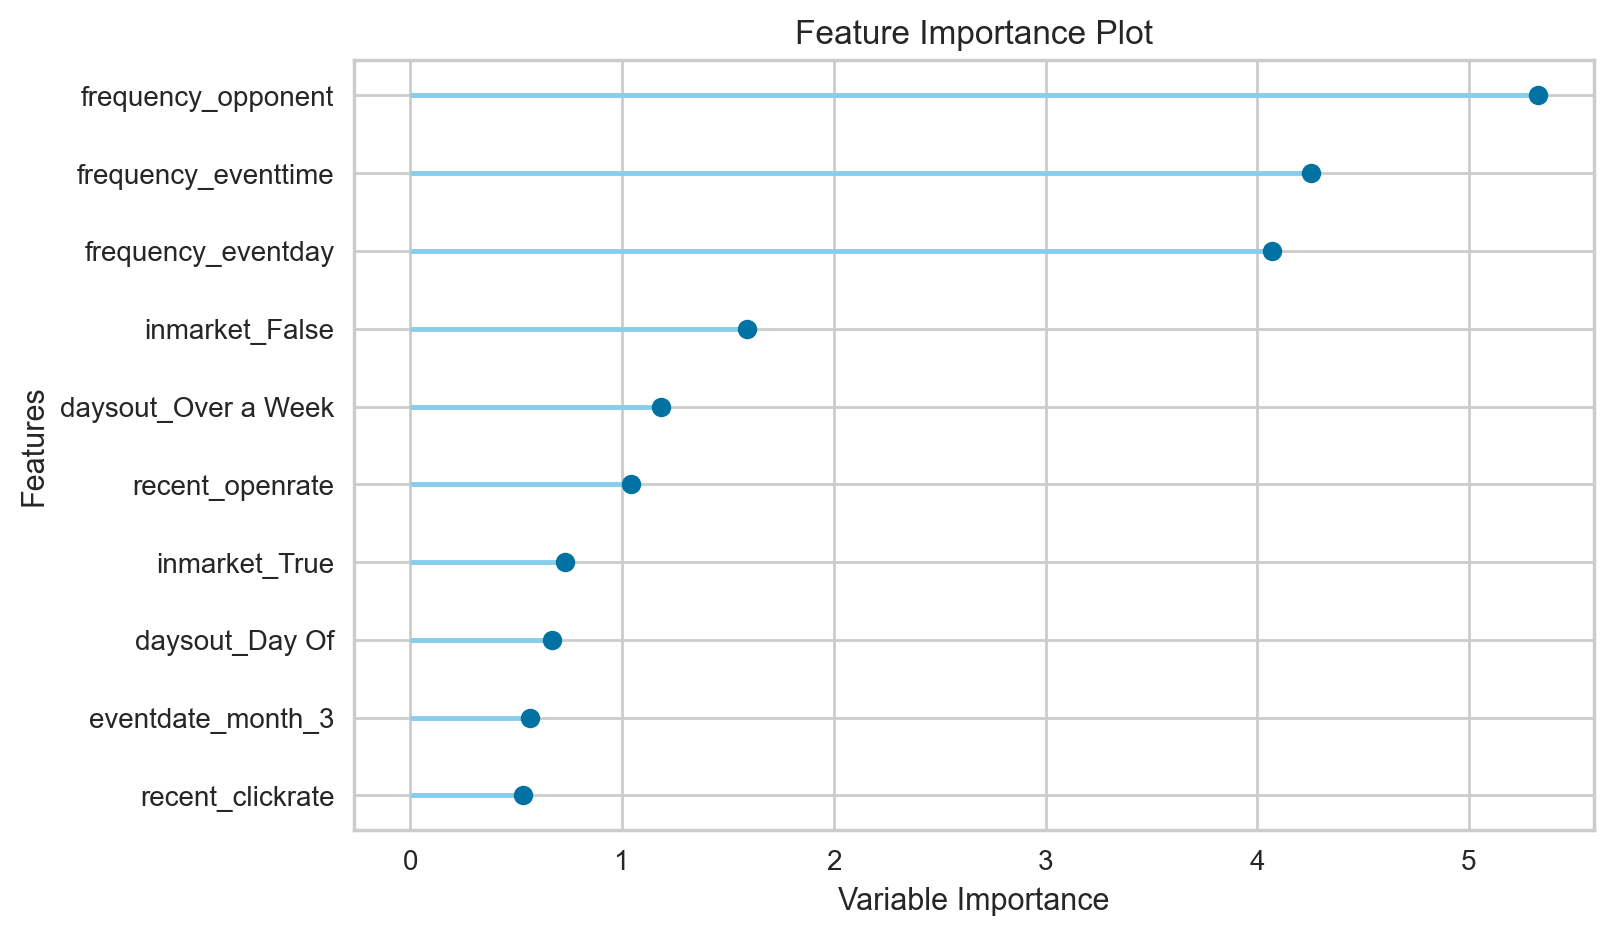

In [32]:
plot_model(best_model, plot='feature')

### This confusion matrix helps understand where the model guessed correctly or incorrectly based on the evaluation data:

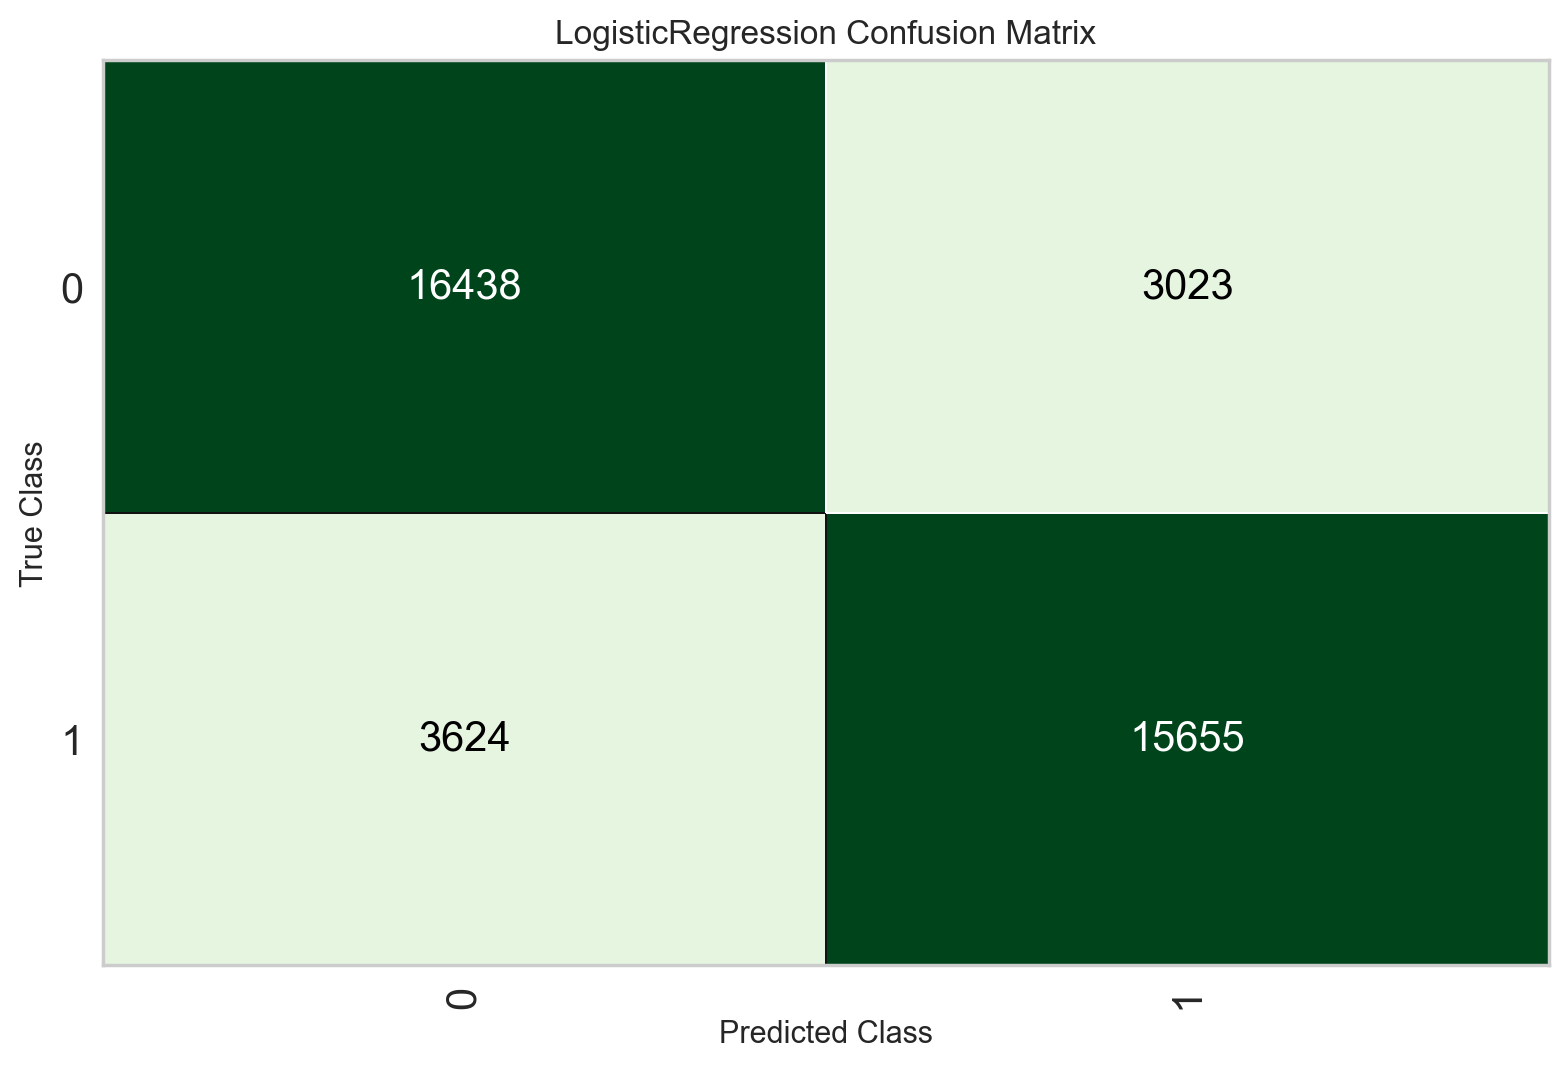

In [33]:
plot_model(best_model, plot='confusion_matrix')

### The AUC curve tells how much the model is capable of distinguishing between classes. The higher the curve, the better the model is at distiguishing classes:

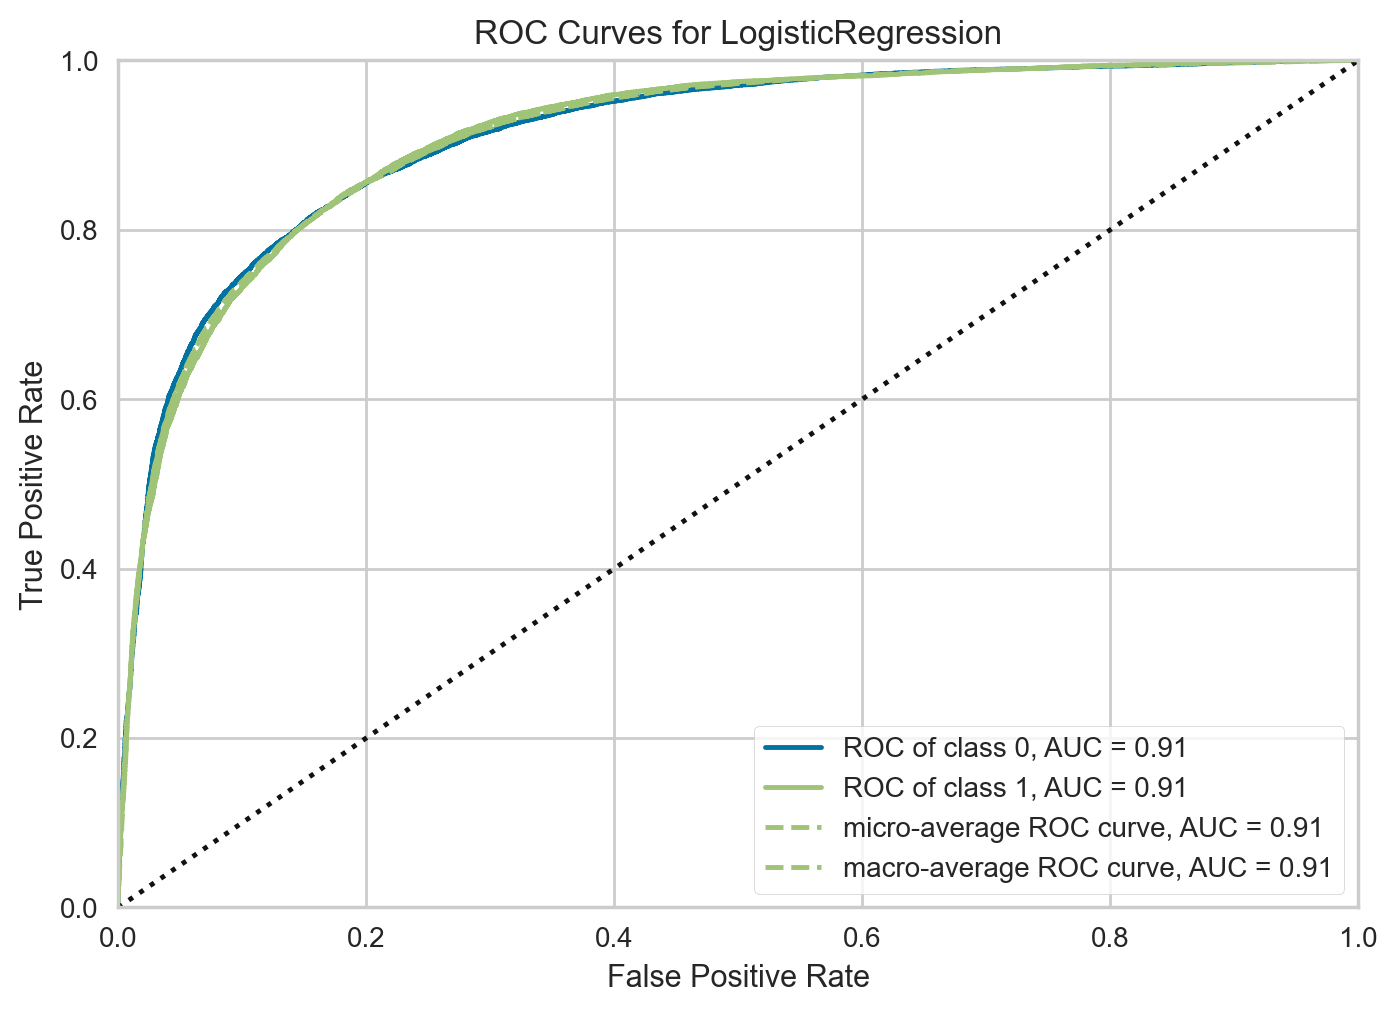

In [34]:
plot_model(best_model, plot='auc')

### Let's load up some real events from previous events to see how the model scores the data:

In [50]:
df_inference = helpers.get_event_propensity_scoring_dataset(
    cluster="prod-app",
    database="stlryankees",
    lkupclientid="53",
    game_date="2019-03-30"
)

df_inference.shape

Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com


(3218440, 12)

In [53]:
# RENAMING SOME COLUMNS:
df_inference = df_inference.rename(columns={
    "daysOut": "daysout", "dimCustomerMasterId": "dimcustomermasterid","eventDate": "eventdate","frequency_eventDay":"frequency_eventday","frequency_eventTime":"frequency_eventtime","inMarket":"inmarket","distanceToVenue":"distancetovenue","recent_openRate":"recent_openrate","recent_clickRate":"recent_clickrate"
})

In [54]:
df_inference.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3218440 entries, 0 to 3218439
Data columns (total 12 columns):
 #   Column               Dtype  
---  ------               -----  
 0   daysout              object 
 1   eventdate            object 
 2   tenure               int64  
 3   dimcustomermasterid  int64  
 4   events_purchased     float64
 5   frequency_opponent   float64
 6   frequency_eventday   float64
 7   frequency_eventtime  float64
 8   inmarket             object 
 9   distancetovenue      float64
 10  recent_openrate      float64
 11  recent_clickrate     float64
dtypes: float64(7), int64(2), object(3)
memory usage: 294.7+ MB


In [56]:
df_inference.eventdate.value_counts()

2019-03-30    3218440
Name: eventdate, dtype: int64

### Let's run the previous scores through the model for predictions:

In [57]:
df_scoring = predict_model(best_model, data=df_inference, raw_score=True)
df_scoring.head()

,daysout,eventdate,tenure,dimcustomermasterid,events_purchased,frequency_opponent,frequency_eventday,frequency_eventtime,inmarket,distancetovenue,recent_openrate,recent_clickrate,Label,Score_0,Score_1
0,Day Of,2019-03-30,2020,2118730,1.0,NaN,NaN,1.0,False,839.63,0.0,0.0,0,0.9800,0.0200
1,1 to 3 Days Out,2019-03-30,2020,2118730,1.0,NaN,NaN,1.0,False,839.63,0.0,0.0,0,0.9733,0.0267
2,4 to 7 Days Out,2019-03-30,2020,2118730,1.0,NaN,NaN,1.0,False,839.63,0.0,0.0,0,0.9765,0.0235
3,Over a Week,2019-03-30,2020,2118730,1.0,NaN,NaN,1.0,False,839.63,0.0,0.0,0,0.8845,0.1155
4,Day Of,2019-03-30,2046,2119691,1.0,NaN,NaN,1.0,False,3937.15,NaN,NaN,0,0.9893,0.0107


### Included are some metrics on did and did_not purchase:

In [58]:
did_purchase = df_scoring["Label"].value_counts()[1]
did_not_purchase = df_scoring["Label"].value_counts()[0]
total_rows = df_scoring["Label"].count()
purchase_percentage = round((did_purchase / total_rows), 4) * 100

print("Would purchase:", did_purchase)
print("Would not purchase:", did_not_purchase)
print("Purchase percentage:", purchase_percentage)

Would purchase: 1589830
Would not purchase: 1628610
Purchase percentage: 49.4


### That purchase percentage seems really high for EP, so let's load in some inference data from a csv populated our old MSSQL proc:

In [68]:
df_inference_2 = pd.read_csv("Yankees_2019_03_30.csv")
df_inference_2.shape

(1648764, 13)

In [69]:
# RENAMING SOME COLUMNS:
df_inference_2 = df_inference_2.rename(columns={
    "daysOut": "daysout", "dimCustomerMasterId": "dimcustomermasterid","eventDate": "eventdate","frequency_eventDay":"frequency_eventday","frequency_eventTime":"frequency_eventtime","inMarket":"inmarket","distanceToVenue":"distancetovenue","recent_openRate":"recent_openrate","recent_clickRate":"recent_clickrate"
})

In [70]:
df_scoring_2 = predict_model(best_model, data=df_inference_2, raw_score=True)
df_scoring_2.head()

,Unnamed: 0,daysout,dimcustomermasterid,eventdate,events_purchased,frequency_opponent,frequency_eventday,frequency_eventtime,inmarket,distancetovenue,recent_openrate,recent_clickrate,tenure,Label,Score_0,Score_1
0,0,Day Of,1671914,2019-03-30,1.0,0.0,0.0,0.022222,True,31.58,NaN,NaN,599,0,0.8292,0.1708
1,1,1 to 3 Days Out,1671914,2019-03-30,1.0,0.0,0.0,0.022222,True,31.58,NaN,NaN,599,0,0.7831,0.2169
2,2,4 to 7 Days Out,1671914,2019-03-30,1.0,0.0,0.0,0.022222,True,31.58,NaN,NaN,599,0,0.8040,0.1960
3,3,Over a Week,1671914,2019-03-30,1.0,0.0,0.0,0.022222,True,31.58,NaN,NaN,599,1,0.4311,0.5689
4,4,Day Of,1732044,2019-03-30,2.0,0.0,0.0,0.000000,True,18.70,0.0,0.0,601,0,0.8482,0.1518


In [71]:
did_purchase = df_scoring_2["Label"].value_counts()[1]
did_not_purchase = df_scoring_2["Label"].value_counts()[0]
total_rows = df_scoring_2["Label"].count()
purchase_percentage = round((did_purchase / total_rows), 4) * 100

print("Would purchase:", did_purchase)
print("Would not purchase:", did_not_purchase)
print("Purchase percentage:", purchase_percentage)

Would purchase: 300862
Would not purchase: 1347902
Purchase percentage: 18.25


### Here we can see the distribution of fans who did and did not purchase : Score_0 = Did Not Purchase, Score_1 = Did Purchase

Text(0.5, 0.98, 'EP Scores')

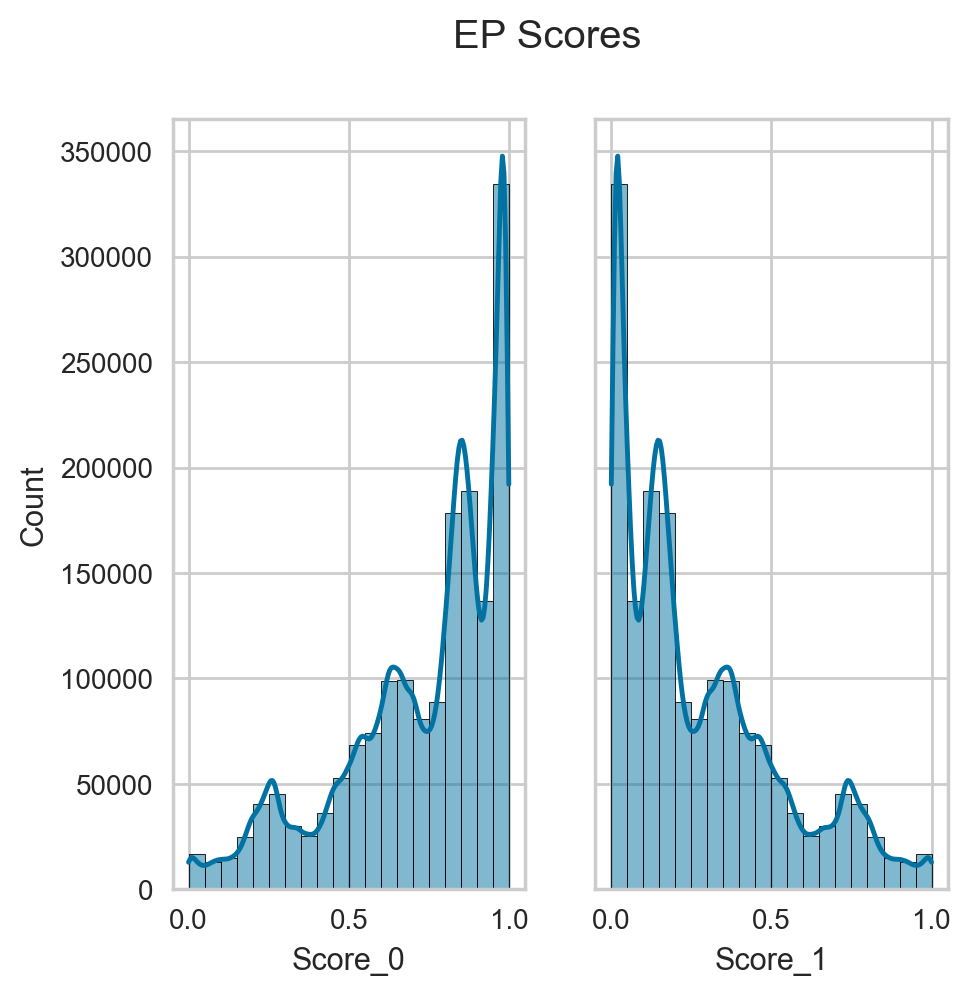

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(5, 5), sharey=True)

sns.histplot(ax=axes[0], data=df_scoring_2, x='Score_0', bins= 20, kde=True)
sns.histplot(ax=axes[1], data=df_scoring_2, x='Score_1', bins= 20, kde=True)

fig.suptitle("EP Scores")

In [ ]:
# scoring_list = df_scoring.to_dict('records')

In [ ]:
# max_dict = {}
# for record in scoring_list:
#     if record['dimCustomerMasterId'] not in max_dict:
#         max_dict[record['dimCustomerMasterId']] = 0
    
#     if record['Score_1'] > max_dict[record['dimCustomerMasterId']]:
#         max_dict[record['dimCustomerMasterId']] = record['Score_1']

In [113]:
#max_scores = [{'id': k, 'score': v} for k, v in max_dict.items()]
#max_scores.sort(key = lambda v: -v["score"])

#df_max_scores = pd.DataFrame(max_scores)
#df_max_scores.to_csv('yankees_scoring_test.csv')

(412191, 2)

In [157]:
# df_max_scores.head()

,id,score
0,1193100,1.0
1,8588,1.0
2,1715715,1.0
3,1836298,1.0
4,24188,1.0


In [124]:
#df1 = df_scoring.loc[df_scoring.groupby('dimCustomerMasterId', sort=False)['Score_1'].idxmax()]

In [128]:
#df1 = df1.sort_values(by='Score_1', ascending=False).reset_index()

In [129]:
#df1 = df1.filter(['dimCustomerMasterId','Score_1'], axis=1)

In [ ]:
#df1.head()

## Observations
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?